In [2]:
import copy
import pickle
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from simantha import Source, Machine, Buffer, Sink, Maintainer, System, utils

random.seed(409)

<a id='toc'></a>
### Verification test cases

#### System behavior tests

Single machine line
- [Single machine line](#single_machine_line)
- [Single machine line with degradation](#single_machine_with_degradation)

Two-machine one-buffer line
- [Two-machine one-buffer line](#two_machine_one_buffer)
- [Two-machine one-buffer line with degradation](#two_machine_one_buffer_degradation)
- [Two-machine one-buffer line with maintenance capacity](#two_machine_one_buffer_capacity)

Parallel station
- [Parallel station line](#parallel_station)
- [Parallel station with degradation](#parallel_station_degradation)

Complex line configuration
- [Complex line](#complex_line)
- [Complex line with degradation](#complex_line_degradation)

Maintenance
- [Condition-based maintenance](#cbm)

#### Simulation functionality tests

- [Iterate simulation](#iterate_simulation)
- [Iterate simulation in parallel](#iterate_simulation_parallel)
- [Continue simulation]()
- [Export simulation state]()

Restart and run all cells to generate intended output.

In [2]:
def export_trace(filepath='trace.csv'):
    # Export the trace of simulation events
    pd.DataFrame(pd.read_pickle('environment_trace.pkl'))[
        ['time', 'location', 'action', 'source']
    ].to_csv(filepath)

In [3]:
def print_execution_profile(machine):
    print('Total execution times:')
    for key, value in machine.execution_profile.items():
        print(f'{key:>20}: {sum(value):<8.6f}s, n={len(value)}')
    
    print('\nMean execution times:')
    for key, value in machine.execution_profile.items():
        print(f'{key:>20}: {np.mean(value):<8.6f}s, n={len(value)}')

<a id='single_machine_line'></a>
### Single machine line
[Top](#toc)

In [3]:
source = Source()
M1 = Machine('M1', cycle_time=2)
sink = Sink()

source.define_routing(downstream=[M1])
M1.define_routing(upstream=[source], downstream=[sink])
sink.define_routing(upstream=[M1])

system = System(objects=[source, M1, sink])

system.simulate(simulation_time=utils.DAY, trace=True)

print(f'\nExpected production: {utils.DAY // M1.cycle_time} units')

Simulation finished in 0.03s
Parts produced: 720

Expected production: 720 units


<a id='single_machine_with_degradation'></a>
### Single machine line with degradation
[Top](#toc)

In [4]:
p = 0.1
h_max = 10
Q = utils.generate_degradation_matrix(p=p, h_max=h_max)

a, b = 20, 30
cm_distribution = {'uniform': [a, b]}

source = Source()
M1 = Machine(
    'M1', 
    cycle_time=2, 
    degradation_matrix=Q, 
    cm_distribution=cm_distribution
)
sink = Sink()

source.define_routing(downstream=[M1])
M1.define_routing(upstream=[source], downstream=[sink])
sink.define_routing(upstream=[M1])

system = System(objects=[source, M1, sink])

system.simulate(simulation_time=utils.WEEK)

mttf = h_max / p
mttr = (a + b) / 2
expected_availability = mttf / (mttf + mttr)
expected_production = (expected_availability * utils.WEEK) / M1.cycle_time

print(f'\nExpected production: {expected_production:.1f} units')

print(f'\nObserved availability: {1 - (M1.downtime / utils.WEEK):.2%}')
print(f'Expected availability: {expected_availability:.2%}')

Simulation finished in 0.15s
Parts produced: 4062

Expected production: 4032.0 units

Observed availability: 80.98%
Expected availability: 80.00%


<a id='two_machine_one_buffer'></a>
### Two-machine one-buffer line
[Top](#toc)

In [5]:
source = Source()
M1 = Machine('M1', cycle_time=1)
B1 = Buffer('B1', capacity=5)
M2 = Machine('M2', cycle_time=1)
sink = Sink()

source.define_routing(downstream=[M1])
M1.define_routing(upstream=[source], downstream=[B1])
B1.define_routing(upstream=[M1], downstream=[M2])
M2.define_routing(upstream=[B1], downstream=[sink])
sink.define_routing(upstream=[M2])

system = System(objects=[source, M1, B1, M2, sink])

system.simulate(simulation_time=utils.DAY)

print(f'\nExpected production: {(utils.DAY - M1.cycle_time) // M2.cycle_time}')

Simulation finished in 0.09s
Parts produced: 1439

Expected production: 1439


<a id='two_machine_one_buffer_degradation'></a>
### Two-machine one-buffer line with degradation
[Top](#toc)

In [6]:
p = 0.1
h_max = 10
Q = utils.generate_degradation_matrix(p=p, h_max=h_max)
a, b = 20, 30
cm_distribution = {'uniform': [a, b]}

source = Source()
M1 = Machine(
    'M1', 
    cycle_time=1, 
    degradation_matrix=Q, 
    cm_distribution=cm_distribution
)
B1 = Buffer('B1', capacity=5)
M2 = Machine(
    'M2', 
    cycle_time=1, 
    degradation_matrix=Q, 
    cm_distribution=cm_distribution
)
sink = Sink()

source.define_routing(downstream=[M1])
M1.define_routing(upstream=[source], downstream=[B1])
B1.define_routing(upstream=[M1], downstream=[M2])
M2.define_routing(upstream=[B1], downstream=[sink])
sink.define_routing(upstream=[M2])

system = System(objects=[source, M1, B1, M2, sink])

system.simulate(simulation_time=utils.WEEK)

mttf = h_max / p
mttr = (a + b) / 2
expected_availability = mttf / (mttf + mttr)
expected_system_availability = expected_availability ** 2
expected_production = (expected_system_availability * utils.WEEK) / max(M1.cycle_time, M2.cycle_time)

print(f'\nApproximate expected production: {expected_production:.2f} units')

print(f'\nExpected availability:    {expected_availability:.2%}')
print(f'M1 observed availability: {1 - (M1.downtime / utils.WEEK):.2%}')
print(f'M2 observed availability: {1 - (M2.downtime / utils.WEEK):.2%}')

Simulation finished in 0.51s
Parts produced: 6797

Approximate expected production: 6451.20 units

Expected availability:    80.00%
M1 observed availability: 79.54%
M2 observed availability: 80.38%


<a id='two_machine_one_buffer_capcaity'></a>
### Two-machine one-buffer line with degradation and maintenance capacity
[Top](#toc)

In [7]:
p = 0.1
h_max = 10
Q = utils.generate_degradation_matrix(p=p, h_max=h_max)
a, b = 20, 30
cm_distribution = {'uniform': [a, b]}

source = Source()
M1 = Machine(
    'M1', 
    cycle_time=1, 
    degradation_matrix=Q, 
    cm_distribution=cm_distribution
)
B1 = Buffer('B1', capacity=5)
M2 = Machine(
    'M2', 
    cycle_time=1, 
    degradation_matrix=Q, 
    cm_distribution=cm_distribution
)
sink = Sink()

source.define_routing(downstream=[M1])
M1.define_routing(upstream=[source], downstream=[B1])
B1.define_routing(upstream=[M1], downstream=[M2])
M2.define_routing(upstream=[B1], downstream=[sink])
sink.define_routing(upstream=[M2])

maintainer = Maintainer(capacity=1)

system = System(objects=[source, M1, B1, M2, sink], maintainer=maintainer)

system.simulate(simulation_time=utils.WEEK, trace=True)

mttf = h_max / p
mttr = (a + b) / 2
expected_availability = mttf / (mttf + mttr)
expected_system_availability = expected_availability ** 2
expected_production = (expected_system_availability * utils.WEEK) / max(M1.cycle_time, M2.cycle_time)

Simulation finished in 0.61s
Parts produced: 6466


In [8]:
pd.DataFrame(M2.maintenance_data)[['time', 'event']]

,time,event
0,90,enter queue
1,90,failure
2,96,begin maintenance
3,122,repaired
4,273,enter queue
...,...,...
306,9895,begin maintenance
307,9920,repaired
308,10060,enter queue
309,10060,failure


<a id='parallel_station'></a>
### Parallel station line
[Top](#toc)

In [9]:
source = Source()
M1 = Machine('M1', cycle_time=3)
M2 = Machine('M2', cycle_time=1)
M3 = Machine('M3', cycle_time=2)
sink = Sink()

source.define_routing(downstream=[M1, M2, M3])
for machine in [M1, M2, M3]:
    machine.define_routing(upstream=[source], downstream=[sink])
sink.define_routing(upstream=[M1, M2, M3])

system = System(objects=[source, M1, M2, M3, sink])

system.simulate(simulation_time=utils.DAY)

expected_production = sum([utils.DAY // machine.cycle_time for machine in [M1, M2, M3]])
print(f'\nExpected production: {expected_production} units')

for machine in [M1, M2, M3]:
    print()
    print(f'{machine.name} expected production: {utils.DAY / machine.cycle_time}')
    print(f'{machine.name} observed production: {machine.parts_made}')

Simulation finished in 0.08s
Parts produced: 2640

Expected production: 2640 units

M1 expected production: 480.0
M1 observed production: 480

M2 expected production: 1440.0
M2 observed production: 1440

M3 expected production: 720.0
M3 observed production: 720


<a id='parallel_station_degradation'></a>
### Parallel station line with degradation
[Top](#toc)

In [10]:
p = 0.1
h_max = 10
Q = utils.generate_degradation_matrix(p=p, h_max=h_max)
a, b = 20, 30
cm_distribution = {'uniform': [a, b]}

source = Source()
M1 = Machine(
    'M1', 
    cycle_time=1,
    degradation_matrix=Q,
    cm_distribution=cm_distribution
)
M2 = Machine(
    'M2', 
    cycle_time=1,
    degradation_matrix=Q,
    cm_distribution=cm_distribution
)
M3 = Machine(
    'M3', 
    cycle_time=1,
    degradation_matrix=Q,
    cm_distribution=cm_distribution
)
sink = Sink()

source.define_routing(downstream=[M1, M2, M3])
for machine in [M1, M2, M3]:
    machine.define_routing(upstream=[source], downstream=[sink])
sink.define_routing(upstream=[M1, M2, M3])

system = System(objects=[source, M1, M2, M3, sink])

system.simulate(simulation_time=utils.DAY)

mttf = h_max / p
mttr = (a + b) / 2
expected_availability = mttf / (mttf + mttr)

expected_production = sum(
    [expected_availability * (utils.DAY // machine.cycle_time) for machine in [M1, M2, M3]]
)
print(f'\nExpected production: {expected_production} units')

for machine in [M1, M2, M3]:
    print()
    print(f'{machine.name} expected availability: {expected_availability:.2%}')
    print(f'{machine.name} observed availability: {1 - (machine.downtime / utils.DAY):.2%}')

Simulation finished in 0.12s
Parts produced: 3487

Expected production: 3456.0 units

M1 expected availability: 80.00%
M1 observed availability: 80.21%

M2 expected availability: 80.00%
M2 observed availability: 79.24%

M3 expected availability: 80.00%
M3 observed availability: 82.71%


<a id='complex_line'></a>
### Complex line
[Top](#toc)

In [11]:
# imported from gmia simulators
import copy
import sys
sys.path.append('../gmia/simulators')

import simantha_complex

In [12]:
random.seed(1)
simantha_complex.system.simulate(simulation_time=7*24*60, trace=True)

Simulation finished in 1.31s
Parts produced: 5148


<a id='complex_line_degradation'></a>
### Complex line with degradation
[Top](#toc)

In [ ]:
system = copy.deepcopy(simantha_complex.system)

system.maintainer.capacity = 3

print(f'Maintenance capacity: {system.maintainer.capacity}\n')

system.simulate(warm_up_time=utils.WEEK, simulation_time=utils.MONTH, trace=False, collect_data=True)
system.simulate(simulation_time=utils.WEEK, trace=True)

In [ ]:
random.seed(1)
#sim.system.simulate(simulation_time=50000)
system = copy.deepcopy(simantha_complex.system)
system.simulate(simulation_time=50000)

<a id='cbm'></a>
### Condition-based maintenance
[Top](#toc)

In [2]:
system = pickle.load(
    open('C:/Users/Michael/Dev/maintenance-planning-mcts/experiments/system_configurations/system_000.pkl', 'rb')
)

In [3]:
system.simulate(simulation_time=1440)

Simulation finished in 0.34s
Parts produced: 1301


<a id='iterate_simulation'></a>
### Iterate simulation
[Top](#toc)

In [4]:
Q = utils.generate_degradation_matrix(p=0.1, h_max=10)
cm_distribution = {'uniform': [10, 30]}

source = Source()
M1 = Machine(
    'M1', 
    cycle_time=1,
    degradation_matrix=Q,
    cm_distribution=cm_distribution
)
B1 = Buffer(capacity=5)
M2a = Machine(
    'M2a', 
    cycle_time=1,
    degradation_matrix=Q,
    cm_distribution=cm_distribution
)
M2b = Machine(
    'M2b',
    cycle_time=1,
    degradation_matrix=Q,
    cm_distribution=cm_distribution
)
B2 = Buffer(capacity=5)
M3 = Machine(
    'M3', 
    cycle_time=1,
    degradation_matrix=Q,
    cm_distribution=cm_distribution
)
sink = Sink()

source.define_routing(downstream=[M1])
M1.define_routing(upstream=[source], downstream=[B1])
B1.define_routing(upstream=[M1], downstream=[M2a, M2b])
for machine in [M2a, M2b]:
    machine.define_routing(upstream=[B1], downstream=[B2])
B2.define_routing(upstream=[M2a, M2b], downstream=[M3])
M3.define_routing(upstream=[B2], downstream=[sink])
sink.define_routing(upstream=[M3])

system = System(objects=[source, M1, B1, M2a, M2b, B2, M3, sink])

system.simulate(simulation_time=utils.WEEK)

Simulation finished in 1.28s
Parts produced: 7237


In [17]:
seedseed = 0
averages = []
for i in range(100):
    result = system.iterate_simulation(
        replications=random.randint(50, 100), 
        warm_up_time=utils.DAY,
        simulation_time=utils.WEEK, 
        jobs=10, 
        seedseed=seedseed
    )
    seedseed += 100
    samples = [r[0] for r in result]
    sample_average = sum(samples) / len(samples)
    averages.append(sample_average)
    print(f'Run {i} mean result: {sample_average} units\n')

Finished 92 replications in 27.55s
Run 0 mean result: 7236.108695652174 units

Finished 76 replications in 20.15s
Run 1 mean result: 7227.3421052631575 units

Finished 92 replications in 26.35s
Run 2 mean result: 7252.141304347826 units

Finished 89 replications in 23.59s
Run 3 mean result: 7252.112359550561 units

Finished 53 replications in 15.03s
Run 4 mean result: 7215.698113207547 units

Finished 93 replications in 29.20s
Run 5 mean result: 7239.731182795699 units

Finished 64 replications in 20.73s
Run 6 mean result: 7245.734375 units

Finished 95 replications in 29.36s
Run 7 mean result: 7226.168421052632 units

Finished 84 replications in 23.05s
Run 8 mean result: 7236.690476190476 units

Finished 93 replications in 29.13s
Run 9 mean result: 7248.645161290323 units

Finished 79 replications in 22.41s
Run 10 mean result: 7214.4177215189875 units

Finished 98 replications in 29.80s
Run 11 mean result: 7223.84693877551 units

Finished 90 replications in 26.41s
Run 12 mean result: 

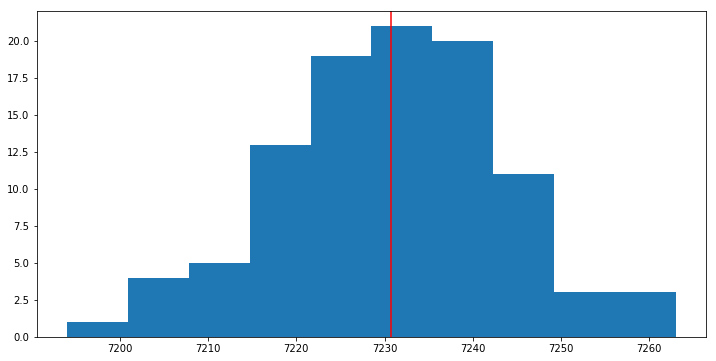

In [18]:
plt.figure(figsize=(12,6))

plt.hist(averages)
plt.axvline(x=sum(averages)/len(averages), color='red')

plt.show()

<a id='iterate_simulation_parallel'></a>
### Iterate simulation in parallel
[Top](#toc)